# Homework 09

## Imports

In [1]:
import os
import glob
import urllib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

from tqdm import tqdm

## Downloading the data
### Downloading categories

In [2]:
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


### Downloading *candle* category data

In [3]:
if not os.path.exists('./data'):
    os.mkdir('./data')

In [4]:
if not os.path.exists('./data/candle.npy'):
    url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/candle.npy'  
    urllib.request.urlretrieve(url,'./data/candle.npy')

In [5]:
images = np.load('./data/candle.npy')

Here is one sample from the data:

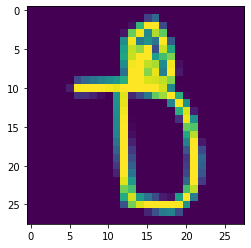

In [6]:
plt.imshow((images[0].reshape((28,28))))

Initial reshaping of the numpy array itself to match 28x28 shape.

In [7]:
data_raw = tf.data.Dataset.from_tensor_slices(np.array([image.reshape(28,28,1) for image in images]))

## Data Pipeline

In [8]:
def preprocess_dataset(data):
    '''We cast the datatype into float32 and normalize'''
    data = data.map(lambda img: (tf.cast((img/128)-1,'float32')))
    '''We shuffle, take a batch size of 64 and prefetch 20 elements.'''
    data = data.shuffle(1000)
    data = data.batch(64)
    data = data.prefetch(20)
    return data

In [9]:
dataset = data_raw.apply(preprocess_dataset)

## Model

In [10]:
class Discriminator(tf.keras.Model):
    def __init__(self, optimizer=tf.keras.optimizers.Adam(0.001)):
        super(Discriminator, self).__init__()
        
        '''This method of optimizer and loss_function implemementation was adapted from the sample solution.'''
        self.optimizer = optimizer
        self.loss_function = tf.keras.losses.BinaryCrossentropy()

        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu')
        self.maxpool1 = tf.keras.layers.MaxPooling2D()
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu')
        self.maxpool2 = tf.keras.layers.MaxPooling2D()
        self.globalavg = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')
        self.dropout = tf.keras.layers.Dropout(rate=0.1)
    
    def call(self, x, is_train=False):
        '''The model\'s call method for forwarding the input through the layers.'''
        x = self.batchnorm1(x,training=is_train)
        x = self.conv1(x)
        x = self.dropout(x, training=is_train)
        x = self.maxpool1(x)
        x = self.batchnorm2(x, training=is_train)
        x = self.conv2(x)
        x = self.dropout(x, training=is_train)
        x = self.maxpool2(x)
        x = self.globalavg(x)
        x = self.output_layer(x)
        return x

In [11]:
class Generator(tf.keras.Model):
    def __init__(self, optimizer=tf.keras.optimizers.Adam(0.001)):
        super(Generator, self).__init__()

        self.optimizer = optimizer
        self.loss_function = tf.keras.losses.BinaryCrossentropy()

        self.input_layer = tf.keras.layers.Dense(units=49, activation='sigmoid')
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        self.tconv1 = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,strides=2,padding='same',activation='relu')
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        self.conv = tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu')
        self.batchnorm3 = tf.keras.layers.BatchNormalization()
        self.tconv2 = tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=3,strides=2,padding='same',activation='relu')
        self.output_layer = tf.keras.layers.Conv2D(filters=1,kernel_size=3,strides=1,padding='same',activation='tanh')
    
    def call(self, inputs, is_train=False):
        '''The model\'s call method for forwarding the input through the layers.'''
        batch_size = inputs.shape[0]
        x = self.input_layer(inputs)
        x = tf.reshape(x, (batch_size,7,7,1))
        x = self.batchnorm1(x,training=is_train)
        x = self.tconv1(x)
        x = self.batchnorm2(x,training=is_train)
        x = self.conv(x)
        x = self.batchnorm3(x,training=is_train)
        x = self.tconv2(x)
        x = self.output_layer(x)
        return x

## Training

In [12]:
generator_loss = {}
discriminator_loss = {}
benchmark_random_vec = tf.random.normal((16,49))
epoch_generator_benchmark = []

In [13]:
def train_step(data,discriminator,generator,generator_loss,discriminator_loss,epoch):
    z = tf.random.normal((data.shape[0],49))
    with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:
            
        fake_data = generator(z, is_train=True)
        fake_data_pred = discriminator(fake_data, is_train=True)
        real_data_pred = discriminator(data, is_train=True)
          
        '''Since our previous implementation's loss functions were the point of critical failure, we have implemented them akin to the tip with tf.ones_like and the sample solution to make sure there is no error left.'''
        G_loss = generator.loss_function(tf.ones_like(fake_data_pred), fake_data_pred) + tf.reduce_sum(generator.losses)
        D_loss = discriminator.loss_function(tf.ones_like(real_data_pred), real_data_pred) + discriminator.loss_function(tf.zeros_like(fake_data_pred), fake_data_pred) + tf.reduce_sum(discriminator.losses)

        discriminator_loss[epoch] += [D_loss]
        generator_loss[epoch] += [G_loss]
            
        D_gradients = D_tape.gradient(D_loss, discriminator.trainable_variables)
        discriminator.optimizer.apply_gradients(zip(D_gradients, discriminator.trainable_variables))

        G_gradients = G_tape.gradient(G_loss, generator.trainable_variables)
        generator.optimizer.apply_gradients(zip(G_gradients, generator.trainable_variables))

In [14]:
def draw_benchmark(epoch_generator_benchmark):
    images = epoch_generator_benchmark[-1]
    num_row = 2
    num_col = 8
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i].reshape(28,28))
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [15]:
def benchmark(generator,benchmark_random_vec,epoch_generator_benchmark):
    epoch_generator_benchmark += [generator(benchmark_random_vec).numpy()]
    print('Drawing benchmark for current epoch:')
    draw_benchmark(epoch_generator_benchmark)

In [16]:
def trainining_loop(dataset,discriminator,generator,epochs,generator_loss,discriminator_loss,benchmark_random_vec,epoch_generator_benchmark):
    '''Initial performance eval'''
    benchmark(generator,benchmark_random_vec,epoch_generator_benchmark)
    
    '''For all epochs'''
    for i in range(epochs):
        for datum in tqdm(dataset,desc='Current epoch: ' + str(i)):
            generator_loss[i] = []
            discriminator_loss[i] = []
            train_step(datum,discriminator,generator,generator_loss,discriminator_loss,i)
        generator_loss[i] = tf.reduce_mean(generator_loss[i]).numpy()
        discriminator_loss[i] = tf.reduce_mean(discriminator_loss[i]).numpy()
        print('Discriminator loss: '+str(discriminator_loss[i]))
        print('Generator loss: '+str(generator_loss[i]))
        benchmark(generator,benchmark_random_vec,epoch_generator_benchmark)

In [17]:
tf.keras.backend.clear_session()

'''Hyperparameters'''
num_epochs = 15

'''Model'''
discriminator = Discriminator()
generator = Generator()

Drawing benchmark for current epoch:


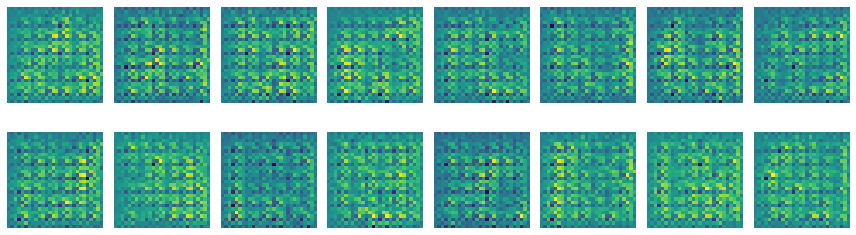

Current epoch: 0: 100%|██████████| 2212/2212 [02:04<00:00, 17.71it/s]


Discriminator loss: 0.1374006
Generator loss: 3.202193
Drawing benchmark for current epoch:


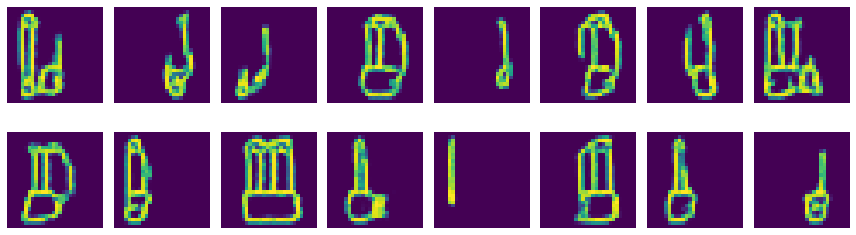

Current epoch: 1: 100%|██████████| 2212/2212 [02:03<00:00, 17.87it/s]


Discriminator loss: 0.15892088
Generator loss: 3.1923137
Drawing benchmark for current epoch:


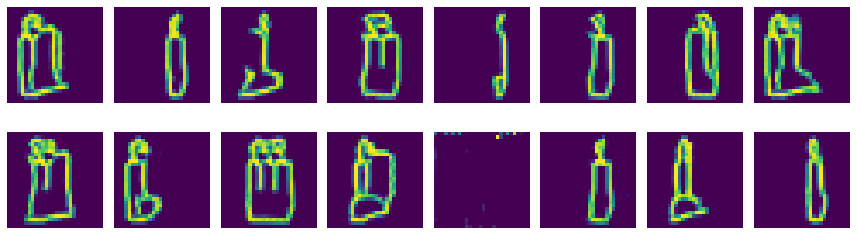

Current epoch: 2: 100%|██████████| 2212/2212 [02:04<00:00, 17.73it/s]


Discriminator loss: 0.089479744
Generator loss: 5.34878
Drawing benchmark for current epoch:


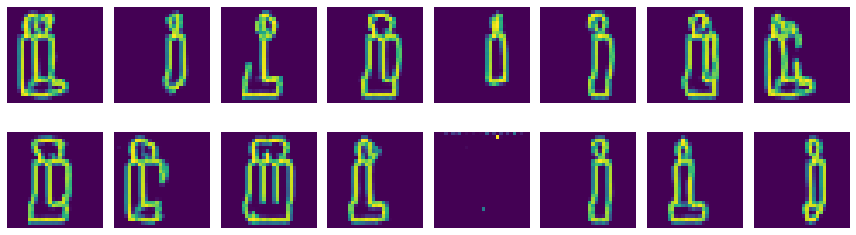

Current epoch: 3: 100%|██████████| 2212/2212 [02:04<00:00, 17.83it/s]


Discriminator loss: 0.22262846
Generator loss: 3.7941542
Drawing benchmark for current epoch:


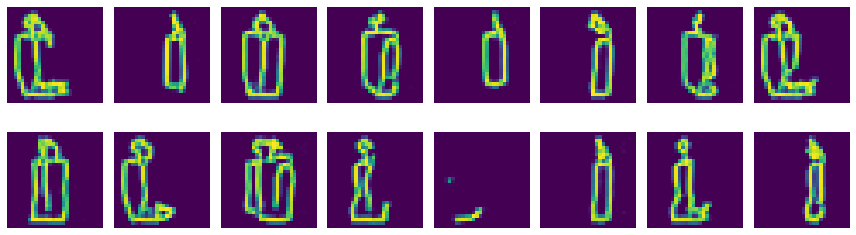

Current epoch: 4: 100%|██████████| 2212/2212 [02:04<00:00, 17.78it/s]


Discriminator loss: 0.18325323
Generator loss: 3.4865625
Drawing benchmark for current epoch:


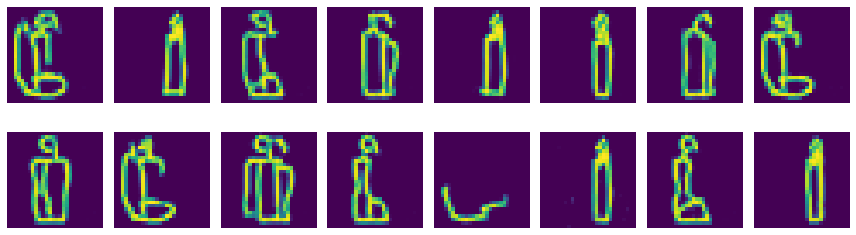

Current epoch: 5: 100%|██████████| 2212/2212 [02:03<00:00, 17.88it/s]


Discriminator loss: 0.10801738
Generator loss: 5.413635
Drawing benchmark for current epoch:


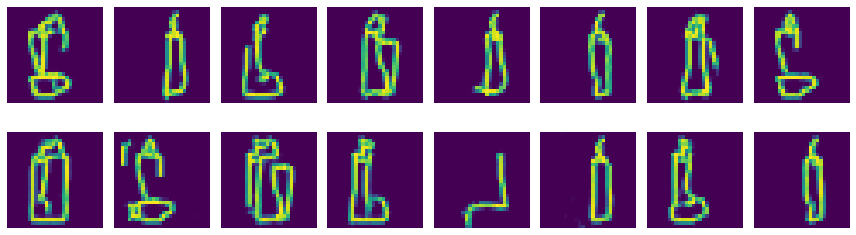

Current epoch: 6: 100%|██████████| 2212/2212 [02:03<00:00, 17.84it/s]


Discriminator loss: 0.16311002
Generator loss: 4.329837
Drawing benchmark for current epoch:


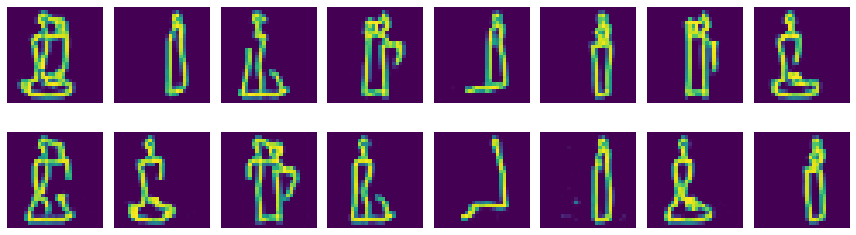

Current epoch: 7: 100%|██████████| 2212/2212 [02:05<00:00, 17.64it/s]


Discriminator loss: 0.21344714
Generator loss: 4.331339
Drawing benchmark for current epoch:


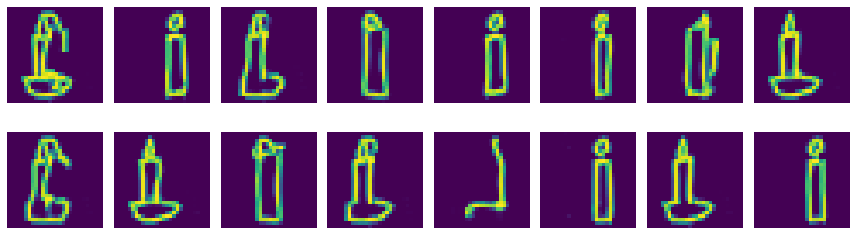

Current epoch: 8: 100%|██████████| 2212/2212 [02:03<00:00, 17.96it/s]


Discriminator loss: 0.059479862
Generator loss: 5.589463
Drawing benchmark for current epoch:


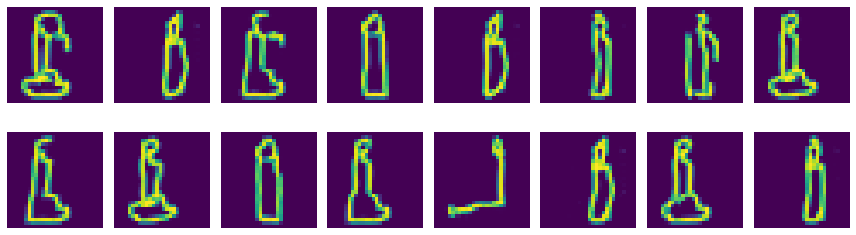

Current epoch: 9: 100%|██████████| 2212/2212 [02:03<00:00, 17.88it/s]


Discriminator loss: 0.10496547
Generator loss: 3.5741272
Drawing benchmark for current epoch:


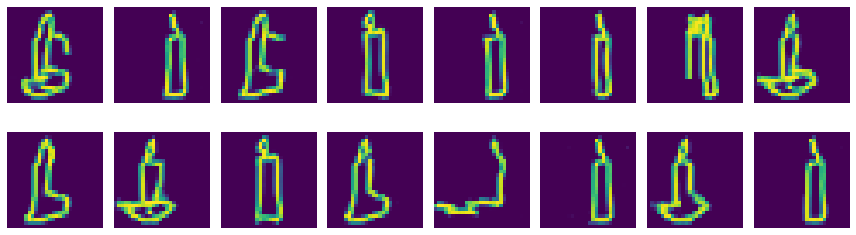

Current epoch: 10: 100%|██████████| 2212/2212 [02:03<00:00, 17.97it/s]


Discriminator loss: 0.10587487
Generator loss: 6.874371
Drawing benchmark for current epoch:


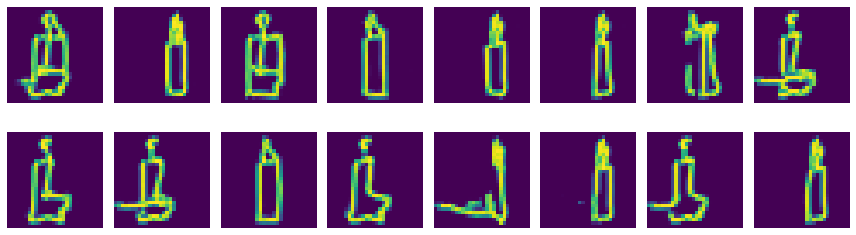

Current epoch: 11: 100%|██████████| 2212/2212 [02:04<00:00, 17.74it/s]


Discriminator loss: 0.08606634
Generator loss: 7.4033227
Drawing benchmark for current epoch:


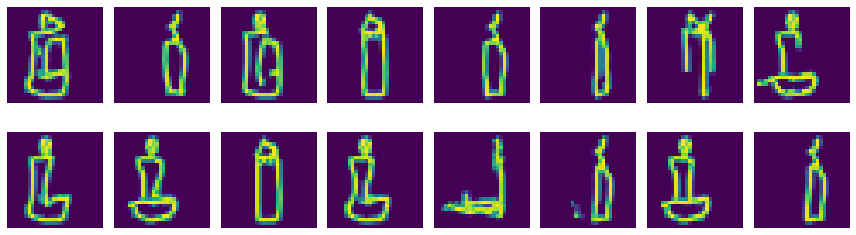

Current epoch: 12: 100%|██████████| 2212/2212 [02:08<00:00, 17.26it/s]


Discriminator loss: 0.08862403
Generator loss: 5.52997
Drawing benchmark for current epoch:


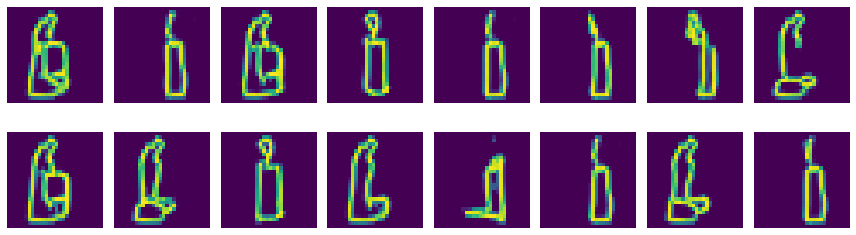

Current epoch: 13: 100%|██████████| 2212/2212 [02:08<00:00, 17.20it/s]


Discriminator loss: 0.21052903
Generator loss: 4.265095
Drawing benchmark for current epoch:


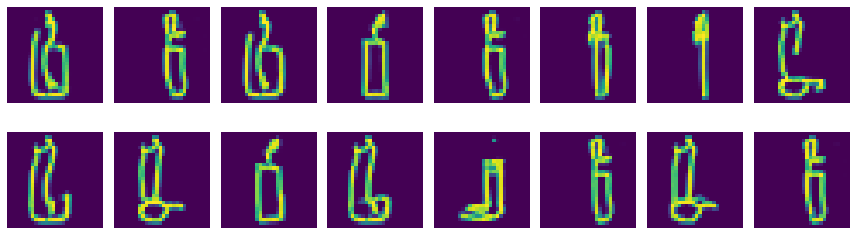

Current epoch: 14: 100%|██████████| 2212/2212 [02:06<00:00, 17.45it/s]


Discriminator loss: 0.08138988
Generator loss: 5.776942
Drawing benchmark for current epoch:


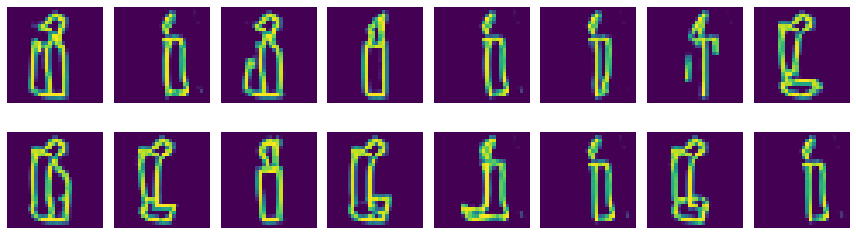

In [18]:
trainining_loop(dataset,discriminator,generator,num_epochs,generator_loss,discriminator_loss,benchmark_random_vec,epoch_generator_benchmark)

In [19]:
def visualize_performance():
    fig, ax = plt.subplots(1,1,figsize=(15, 4))
    line1, = ax.plot(list(discriminator_loss.values()))
    line2, = ax.plot(list(generator_loss.values()))
    ax.set_xlabel("Training epoch")
    ax.set_ylabel("Loss")
    ax.legend((line1,line2),("discriminator","generator"))
    plt.show()

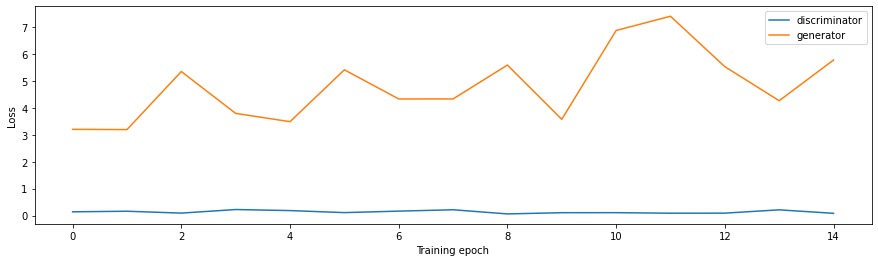

In [20]:
visualize_performance()